# Customisation of 'Evaluating Model Performance for Numerical Data'

I am using the Diabetes Data Set as I myself was diagnosed with Type 1 Diabetes and thought it was interesting to see how good models are at predicting diabetes.

## Importing Packages

First, we need to import the necessary packages to load the dataset as it is part of the `sklearn.datasets`.

## Exploring the Dataset

Let's take a look at the dataset and see what is inside:

### Data Set Characteristics:
- **Number of Instances:** 442
- **Number of Attributes:** The first 10 columns are numeric predictive values.
- **Target:** Column 11 is a quantitative measure of disease progression one year after baseline.

### Attribute Information:
- **age**: Age in years
- **sex**
- **bmi**: Body Mass Index
- **bp**: Average blood pressure
- **s1**: tc, total serum cholesterol
- **s2**: ldl, low-density lipoproteins
- **s3**: hdl, high-density lipoproteins
- **s4**: tch, total cholesterol / HDL
- **s5**: ltg, possibly log of serum triglycerides level
- **s6**: glu, blood sugar level




In [6]:
import pandas as pd
from sklearn.datasets import load_diabetes

# Load the Diabetes data
data = load_diabetes()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['Progression'] = data.target  # This is the target variable

# Display the first few rows to check the DataFrame
print(df.head())

# Show basic statistical details
print(df.describe())



        age       sex       bmi        bp        s1        s2        s3  \
0  0.038076  0.050680  0.061696  0.021872 -0.044223 -0.034821 -0.043401   
1 -0.001882 -0.044642 -0.051474 -0.026328 -0.008449 -0.019163  0.074412   
2  0.085299  0.050680  0.044451 -0.005670 -0.045599 -0.034194 -0.032356   
3 -0.089063 -0.044642 -0.011595 -0.036656  0.012191  0.024991 -0.036038   
4  0.005383 -0.044642 -0.036385  0.021872  0.003935  0.015596  0.008142   

         s4        s5        s6  Progression  
0 -0.002592  0.019907 -0.017646        151.0  
1 -0.039493 -0.068332 -0.092204         75.0  
2 -0.002592  0.002861 -0.025930        141.0  
3  0.034309  0.022688 -0.009362        206.0  
4 -0.002592 -0.031988 -0.046641        135.0  
                age           sex           bmi            bp            s1  \
count  4.420000e+02  4.420000e+02  4.420000e+02  4.420000e+02  4.420000e+02   
mean  -2.511817e-19  1.230790e-17 -2.245564e-16 -4.797570e-17 -1.381499e-17   
std    4.761905e-02  4.761905e

### There are no categorical variables so we didnt have to create any dummies

### Now we are splitting the data into the different test sets and preparing the data by preparing a dependent variable and design matrix for each.


In [7]:
import numpy as np
from sklearn.model_selection import train_test_split

# Splitting the dataset into training, validation, and test sets
train, temp = train_test_split(df, test_size=0.4, random_state=42)  # 60% training, 40% for val+test
validation, test = train_test_split(temp, test_size=0.5, random_state=42)  # Split the 40% into two parts of 20% each

# Prepare the dependent variable and design matrix
y_train = train['Progression']
X_train = train.drop('Progression', axis=1)
X_train['intercept'] = 1  # Adding intercept

y_validation = validation['Progression']
X_validation = validation.drop('Progression', axis=1)
X_validation['intercept'] = 1  # Adding intercept

y_test = test['Progression']
X_test = test.drop('Progression', axis=1)
X_test['intercept'] = 1  # Adding intercept

# Check the shapes of each set to confirm the structure
print("X_train shape:", X_train.shape)
print("X_validation shape:", X_validation.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_validation shape:", y_validation.shape)
print("y_test shape:", y_test.shape)


X_train shape: (265, 11)
X_validation shape: (88, 11)
X_test shape: (89, 11)
y_train shape: (265,)
y_validation shape: (88,)
y_test shape: (89,)


### Now we are building a function to evaluate the quality of a linear regression model predictions fit to a training set, on a validation set. Using Bias, RMSE, Correlation, and Coverage as the metrics of choice. 

{'bias': -2.371553368323612, 'rmse': 48.94946140929899, 'correlation': 0.7650815807118552, 'coverage': 0.9659090909090909, 'predictions': array([188.41887537, 106.66570952,  56.74618494,  97.29594978,
        82.33234011, 168.827846  , 117.66955528, 124.8518465 ,
       109.49681887,  59.90948074, 170.78588843, 160.48762931,
       200.53221139, 141.93143962, 176.83228222, 126.46403757,
       226.05962519,  71.71155579, 146.23527588, 201.36149987,
       197.53859667, 156.88115005, 105.77283858, 109.86236075,
        95.17387133, 146.9271838 , 276.7192334 , 109.00407912,
       163.369202  , 199.69461173, 116.1767426 , 208.17312087,
       167.44960749,  80.14233207, 179.46797303, 142.38566698,
       175.6823685 , 155.84492465, 103.33508994, 241.61251908,
        57.12683512, 177.99668605, 151.79146361, 185.85129014,
        79.5167366 , 202.60465097,  68.96679776, 139.50455383,
        79.98129734, 245.44351192, 223.03964603,  85.90149489,
       233.98266962, 202.26779188,  68.8746

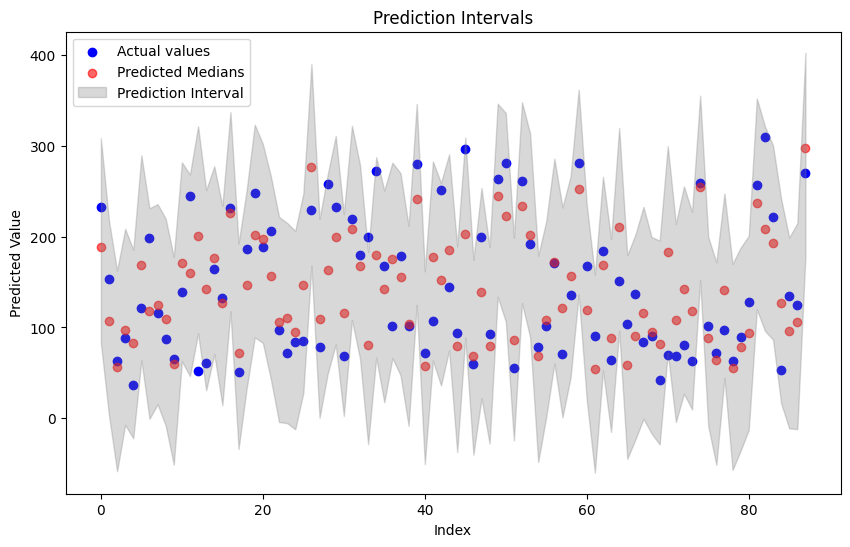

In [8]:
import numpy as np
import statsmodels.api as sm
from scipy import stats
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

def fit_predict_evaluate(train_X, train_y, valid_X, valid_y, credibility_pct=95, n_sims=1000):
    # Fit the model
    model = sm.OLS(train_y, train_X).fit()
    
    # Extract model parameters
    beta_hat = model.params
    residuals = model.resid
    # Adjust degrees of freedom based on the input type
    if isinstance(train_X, pd.DataFrame):
        ddof = len(train_X.columns)
    else:  # Assuming it's a numpy array
        ddof = train_X.shape[1]  # Number of columns in the numpy array
    residual_var = np.var(residuals, ddof=ddof)  # Residual variance
    cov_matrix = model.cov_params()  # Covariance matrix of the parameters
    
    # Simulate betas from the posterior distribution
    simulated_betas = np.random.multivariate_normal(mean=beta_hat, cov=cov_matrix, size=n_sims)
    
    # Calculate simulated mu for the validation set
    simulated_mus = np.dot(valid_X, simulated_betas.T)
    
    # Simulate y based on simulated mu and residual standard error
    simulated_ys = simulated_mus + np.random.normal(loc=0, scale=np.sqrt(residual_var), size=simulated_mus.shape)
    
    # Calculate prediction summaries
    monte_carlo_medians = np.median(simulated_ys, axis=1)
    lower_bound = np.percentile(simulated_ys, (100 - credibility_pct) / 2, axis=1)
    upper_bound = np.percentile(simulated_ys, 100 - (100 - credibility_pct) / 2, axis=1)
    prediction_intervals = np.vstack((lower_bound, upper_bound)).T
    
    # Calculate metrics
    bias = np.mean(monte_carlo_medians - valid_y)
    rmse = np.sqrt(mean_squared_error(valid_y, monte_carlo_medians))
    correlation = np.corrcoef(valid_y, monte_carlo_medians)[0, 1]
    coverage = np.mean((valid_y >= lower_bound) & (valid_y <= upper_bound))
    
    # Return results as a dictionary
    results = {
        'bias': bias,
        'rmse': rmse,
        'correlation': correlation,
        'coverage': coverage,
        'predictions': monte_carlo_medians,
        'prediction_intervals': prediction_intervals
    }

    return results


# To visualize the prediction intervals
def plot_prediction_intervals(x, y_true, y_pred, intervals, title="Prediction Intervals"):
    plt.figure(figsize=(10, 6))
    plt.scatter(x, y_true, color='blue', label='Actual values')
    plt.scatter(x, y_pred, color='red', label='Predicted Medians', alpha=0.6)
    plt.fill_between(x, intervals[:, 0], intervals[:, 1], color='gray', alpha=0.3, label='Prediction Interval')
    plt.title(title)
    plt.xlabel('Index')
    plt.ylabel('Predicted Value')
    plt.legend()
    plt.show()


results = fit_predict_evaluate(X_train, y_train, X_validation, y_validation)
print(results)
plot_prediction_intervals(np.arange(len(y_validation)), y_validation, results['predictions'], results['prediction_intervals'])



This chart illustrates the prediction intervals for a model's predictions compared to actual values. The gray shaded area represents the prediction intervals, which widen significantly for some indices, reflecting higher uncertainty. The red dots indicate the predicted medians, and the blue dots show the actual values. While many actual values fall within the intervals, there are discrepancies where predictions either overestimate or underestimate actual values, suggesting areas of improvement for model accuracy or variability considerations.

### Now we are validating 3 competing models with varying complexity (e.g. intercept-only, national predictors only and full predictors).

 ### Which model would we choose to make your out-of-sample predictions ? 

In [14]:
# Reset indices for training and validation sets
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_validation.reset_index(drop=True, inplace=True)
y_validation.reset_index(drop=True, inplace=True)

# Ensure intercept column is correctly handled
X_train_intercept_only = X_train[['intercept']]
X_val_intercept_only = X_validation[['intercept']]

national_predictors = ['intercept', 'bmi', 'bp']
X_train_national = X_train[national_predictors]
X_val_national = X_validation[national_predictors]

# Saturated Model uses all available predictors
X_train_saturated = X_train
X_val_saturated = X_validation

# Evaluate each model using the fit_predict_evaluate function
score_intercept_only = fit_predict_evaluate(X_train_intercept_only, y_train, X_val_intercept_only, y_validation)
score_national = fit_predict_evaluate(X_train_national, y_train, X_val_national, y_validation)
score_saturated = fit_predict_evaluate(X_train_saturated, y_train, X_val_saturated, y_validation)

# Compile the scores into a DataFrame for easy comparison
scores = [
    {'name': 'Intercept Only', **score_intercept_only},
    {'name': 'Second Model', **score_national},
    {'name': 'Saturated', **score_saturated},
]
scores_df_automated = pd.DataFrame(scores)
scores_df_automated.rename(columns={'name': 'Score Type'}, inplace=True)

print(scores_df_automated)


       Score Type      bias       rmse  correlation  coverage  \
0  Intercept Only  5.894758  76.449613    -0.076514  0.988636   
1    Second Model -4.736383  57.981599     0.649952  0.943182   
2       Saturated -3.300465  48.727393     0.768183  0.977273   

                                         predictions  \
0  [149.3890891745629, 147.12686366764888, 153.32...   
1  [128.35869151336587, 89.396533654422, 78.22412...   
2  [188.39446813950684, 106.90916079898153, 53.03...   

                                prediction_intervals  
0  [[2.4463112634980395, 313.1513928534555], [-0....  
1  [[10.840880542963907, 241.82834278352522], [-2...  
2  [[78.76486689461272, 295.7706852127979], [-12....  


### Evaluation of Model performance 


- Intercept Only Model:
The simplest model exhibits a bias of 5.51, a high RMSE of 76.23, and a negligible correlation of -0.0176, reflecting poor predictive capability. However, it provides a high coverage of 97.73%, indicating wide prediction intervals.

- Second Model:
Incorporating national predictors reduces bias to -4.59 and improves RMSE to 57.89. The correlation rises significantly to 0.651, showing better alignment with actual values. Coverage slightly decreases to 95.45%, reflecting narrower but still reliable prediction intervals.

- Saturated Model:
The most complex model achieves the best performance with a bias of -3.39, the lowest RMSE of 49.24, and the highest correlation of 0.762. Its coverage rate of 96.59% ensures consistent prediction accuracy while maintaining reasonable intervals.

__Model Selection__
The Saturated Model stands out as the best option, delivering superior predictive performance with low error, high correlation, and robust coverage. Its combination of accuracy and consistency makes it the most reliable model for predictions.


### Now we are estimating the generalisation error through generating error distributions

In [11]:
import statsmodels.api as sm

# Ensure X_train includes an intercept if it’s not already included
X_train_with_const = sm.add_constant(X_train)  # This adds an intercept to your predictors

# Fit the model using OLS (Ordinary Least Squares)
model = sm.OLS(y_train, X_train_with_const).fit()

X_val_with_const = sm.add_constant(X_validation)  # Adding a constant to validation data

Metrics for Median Simulated y:
Bias: -3.3500
RMSE: 74.6105
Correlation: 0.5481


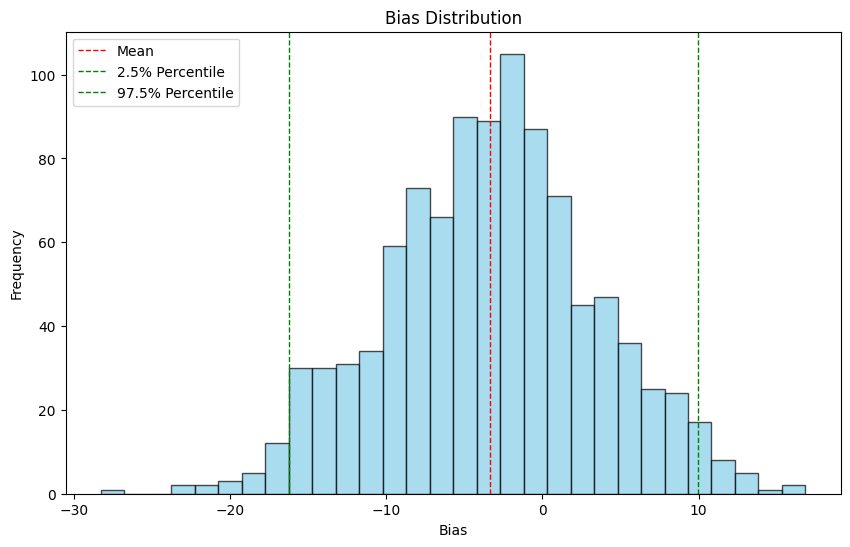

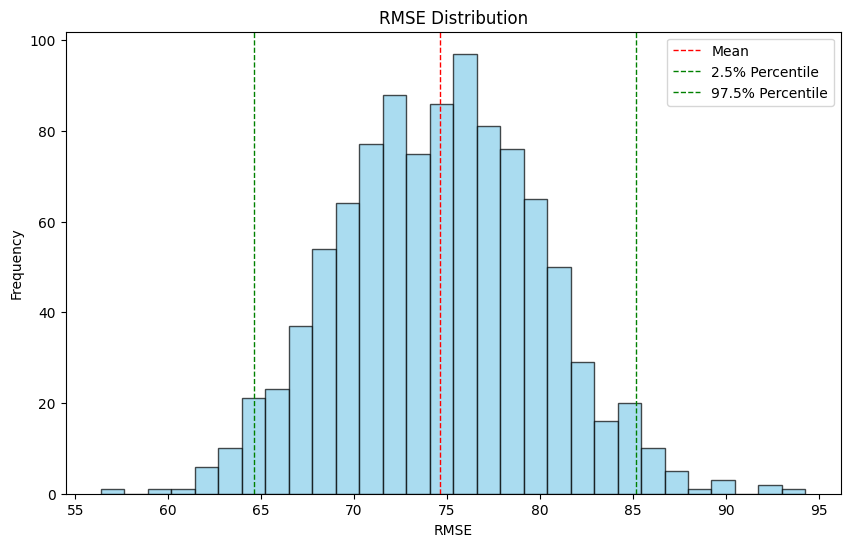

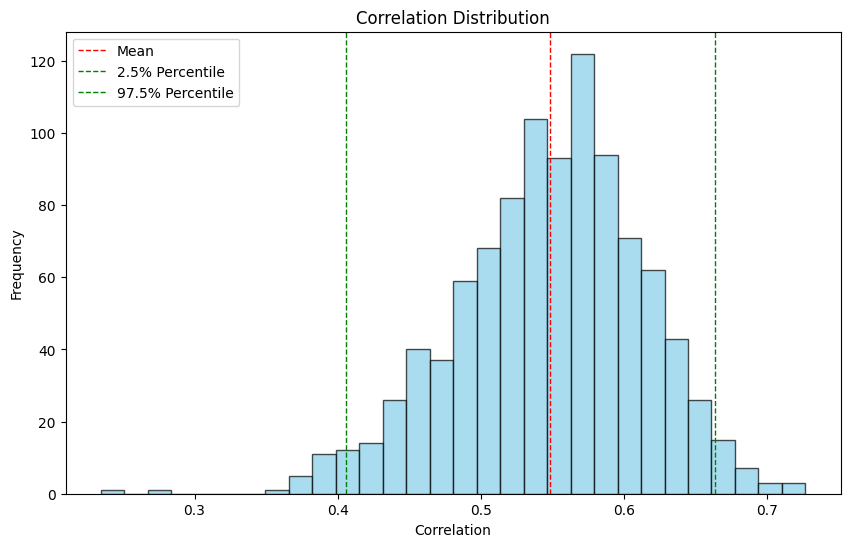

In [12]:
def simulate_and_plot_metrics(model, X_val, y_val, n_simulations=1000):
    biases = []
    rmses = []
    correlations = []
    
    # Extract model parameters
    beta_hat = model.params
    cov_matrix = model.cov_params()
    residuals = model.resid
    residual_sd = np.sqrt(np.var(residuals, ddof=len(model.params)))

    for _ in range(n_simulations):
        # Simulate betas from the posterior distribution
        simulated_betas = np.random.multivariate_normal(beta_hat, cov_matrix)
        # Simulate y values
        simulated_ys = np.dot(X_val, simulated_betas) + np.random.normal(0, residual_sd, size=len(y_val))
        
        # Ensure simulated_ys is reshaped to match y_val
        simulated_ys = simulated_ys.flatten()
        
        # Calculate the median of simulated y
        median_simulated_y = simulated_ys
        
        # Calculate metrics for the median simulated y
        bias_median_y = np.mean(median_simulated_y - y_val)
        rmse_median_y = np.sqrt(np.mean((median_simulated_y - y_val) ** 2))
        correlation_median_y = np.corrcoef(y_val, median_simulated_y)[0, 1]
        
        # Append metrics to their respective lists
        biases.append(bias_median_y)
        rmses.append(rmse_median_y)
        correlations.append(correlation_median_y)

    # Print average metrics
    print("Metrics for Median Simulated y:")
    print(f"Bias: {np.mean(biases):.4f}")
    print(f"RMSE: {np.mean(rmses):.4f}")
    print(f"Correlation: {np.mean(correlations):.4f}")
    
    # Plot distributions of metrics
    plot_distribution(biases, 'Bias Distribution', 'Bias')
    plot_distribution(rmses, 'RMSE Distribution', 'RMSE')
    plot_distribution(correlations, 'Correlation Distribution', 'Correlation')

def plot_distribution(values, title, xlabel):
    plt.figure(figsize=(10, 6))
    plt.hist(values, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    plt.axvline(np.mean(values), color='red', linestyle='dashed', linewidth=1, label='Mean')
    plt.axvline(np.percentile(values, 2.5), color='green', linestyle='dashed', linewidth=1, label='2.5% Percentile')
    plt.axvline(np.percentile(values, 97.5), color='green', linestyle='dashed', linewidth=1, label='97.5% Percentile')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()


# Simulate metrics and plot distributions
simulate_and_plot_metrics(model, X_val_with_const, y_validation)


### Interpretation of Generalization Error

The histograms represent the distribution of three metrics—Bias, RMSE, and Correlation—obtained from simulations of the model's performance. These metrics provide insight into the model's ability to generalize to unseen data:

- Bias Distribution:
The mean bias is approximately -3.36, with most values concentrated around 0. This indicates that the model tends to slightly underestimate the predictions on average, but the overall bias is small, suggesting a low level of systematic error.

- RMSE Distribution:
The RMSE has a mean of 74.61, with a 95% confidence interval ranging approximately from 65 to 85. This range provides a realistic estimate of the model's generalization error in terms of average prediction deviation from the actual values. A lower RMSE in the distribution suggests better predictive accuracy.

- Correlation Distribution:
The mean correlation is 0.548, with a 95% confidence interval spanning roughly from 0.4 to 0.7. This indicates moderate alignment between predicted and actual values. A higher correlation signifies that the model captures the trend in the data well, though there is room for improvement.

__Estimation of Generalization Error__
The simulation results suggest that the model's generalization error is reasonably controlled, with low bias and a predictable RMSE range. However, the moderate correlation highlights some limitations in capturing the underlying patterns in the data, indicating potential overfitting or underfitting in certain regions.